# Introdução ao KNN
A idéia por trás do kNN é que pontos de dados semelhantes devem ter a mesma classe, pelo menos na maioria das vezes. Esse método é muito intuitivo e já provou em muitos domínios, incluindo sistemas de recomendação, detecção de anomalias e classificação de imagens / textos.

Por exemplo, considere um caso em que você deseja classificar uma imagem como um dos 2000 tipos possíveis, como "pessoa", "animal", "ao ar livre", "oceano", "pôr do sol" e assim por diante. Dada uma função de distância adequada entre as imagens, a classificação de uma imagem não rotulada pode ser determinada pelas etiquetas atribuídas aos seus vizinhos mais próximos, ou seja, as imagens rotuladas que estão mais próximas a ela, de acordo com a função de distância.


### Prós

**Qualidade de previsão** : Um classificador kNN é capaz de recuperar partições não estruturadas do espaço, ao contrário de, digamos, um classificador linear que requer uma separação linear entre as classes. Ele também pode se adaptar a diferentes densidades no espaço, tornando-o mais robusto do que métodos lineares. Os dois exemplos de dados 2D a seguir ilustram diferentes partições do espaço impostas por dados rotulados e a previsão de um modelo kNN nesse espaço.

<img src="img/sagemaker-knn-1.gif">


**Ciclos curtos** : Outra vantagem do kNN é que há pouco ou nenhum treinamento envolvido. Isso significa que iterar sobre diferentes métricas / modificações possíveis do conjunto de dados de entrada é potencialmente mais rápido quando comparado a um classificador que requer um procedimento de treinamento pesado, como redes neurais profundas, ou mesmo funções SVM.

**Muitas classes de saída** : o kNN pode manipular facilmente um grande número de classes. Para comparação, um modelo linear ou uma rede neural profunda com  deve calcular explicitamente uma pontuação para cada classe possível e escolher a melhor. Imagine, por exemplo, uma tarefa de reconhecer tipos de flores por sua imagem ou por um conjunto de suas características, para as quais temos 100 mil exemplos de características e 5 mil exemplos de tipos de flores. Qualquer modelo que aprenda explicitamente 5mil conjuntos de parâmetros para identificar cada tipo de flor pode ser facilmente propenso a overfiting, o que significa que pode produzir respostas erradas.

**Interpretabilidade** : A previsão de um modelo kNN é baseada na similaridade aos objetos existentes. Como resultado, a pergunta “por que meu exemplo recebeu a classe X?” É respondida assim: “porque itens semelhantes são rotulados com X.” Por exemplo, considere um modelo que avalie o risco envolvido com um empréstimo. No exemplo, um cliente foi considerado de alto risco porque 8 de 10 clientes que foram avaliados anteriormente e eram mais semelhantes a eles em termos de X, Y e Z, foram considerados de alto risco. Ao observar os vizinhos mais próximos, você pode ver objetos semelhantes ao exemplo que são rotulados como X, e você pode decidir se a previsão faz sentido.

### Contras

**Predição custosa**: A principal desvantagem do kNN é sua inferência cara. Para inferir o rótulo de uma consulta de entrada, precisamos encontrar os pontos de dados mais próximos a ela. Uma solução ingênua manteria todos os pontos de dados na memória e, dada uma consulta, calcularia a distância entre ela e todos os pontos de dados. Para quantidades concretas, se o conjunto de treinamento continha n pontos de dados de d dimensões, este processo requer operações aritméticas nd.

# HandsOn

Vamos usar o dataset sobre os jogadores da NBA em 2013 para prever seus pontos em 2014 utilizando KNN.

Antes de começarmos algumas informações das colunas.

    player - nome do jogador
    pos - a posição do jogador
    g - número de jogos em que o jogador estava
    gs - número de jogos que o jogador iniciou
    pts - total de pontos que o jogador marcou
    
Há muito mais colunas nos dados, a maioria contendo informações sobre o desempenho médio dos jogadores durante a temporada. 

Veja este site para uma explicação sobre o resto deles: https://www.rotowire.com/

In [1]:
import pandas as pd

nba = pd.read_csv('nba_2013.csv')
print(nba.shape)
nba.head()

(481, 31)


,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


**Visão geral da KNN**

O algoritmo de k vizinhos mais próximos baseia-se na ideia simples de prever valores desconhecidos, combinando-os com os valores conhecidos mais semelhantes.

Vamos dizer que temos 3 tipos diferentes de carros. Sabemos o nome do carro, sua potência, se tem listras ou não, e se é ou não rápido:

    car,horsepower,racing_stripes,is_fast
    Honda Accord,180,False,False
    Yugo,500,True,True
    Delorean DMC-12,200,True,True
    
Digamos que agora temos outro carro, mas não sabemos o quão rápido é:

    car,horsepower,racing_stripes,is_fast
    Chevrolet Camaro,400,True,Unknown
    
Queremos descobrir se o carro é rápido ou não. Para prever se é com k vizinhos mais próximos, primeiro encontramos o carro conhecido mais similar. Nesse caso, comparamos os valores horsepowere racing_stripespara encontrar o carro mais parecido, que é o Yugo. Como o Yugo é rápido, nós preveríamos que o Camaro também é rápido. Este é um exemplo de 1 vizinho mais próximo - nós olhamos apenas para o carro mais similar, dando-nos um k de 1.

Se nós executássemos os 2 vizinhos mais próximos, acabaríamos com 2 Truevalores (para o Delorean e o Yugo), o que significaria média para True. O Delorean e Yugo são os dois carros mais parecidos, nos dando um k de 2.

Se fizéssemos 3 vizinhos mais próximos, acabaríamos com 2 Truevalores e um Falsevalor, o que significaria média para True.

O número de vizinhos que usamos para os k vizinhos mais próximos (k) pode ser qualquer valor menor que o número de linhas em nosso conjunto de dados. Na prática, observar apenas alguns vizinhos faz com que o algoritmo tenha um melhor desempenho, porque quanto menos semelhantes os vizinhos forem aos nossos dados, pior será a previsão.

**Distância euclidiana**

Antes de podermos prever usando o KNN, precisamos encontrar alguma maneira de descobrir quais linhas de dados estão "mais próximas" da linha que estamos tentando prever.

<img src='img/347a4b535ffd805ffdf332e51905bcdf4764f663.svg'>

Digamos que temos essas duas linhas e queremos encontrar a distância entre elas:

    car,horsepower,is_fast
    Honda Accord,180,0
    Chevrolet Camaro,400,1
    
Primeiro, selecionamos apenas as colunas numéricas. Então a distância se torna:

$\sqrt {(400-180)^ 2 + (1-0)^2 } = 220$


Podemos usar o princípio da distância euclidiana para encontrar os jogadores mais similares da NBA para **Lebron James**.

In [2]:
# Seleciona o mito
selected_player = nba[nba["player"] == "LeBron James"].iloc[0]

# Escolhe as variáveis numéricas para calcularmos a distância.
distance_columns = ['age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg.', 'x3p', 'x3pa', 'x3p.', 'x2p', 'x2pa', 'x2p.', 'efg.', 'ft', 'fta', 'ft.', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

In [3]:
import math

def euclidean_distance(row):
    inner_value=0
    for k in distance_columns:
        inner_value += (row[k] - selected_player[k]) ** 2
    return math.sqrt(inner_value)

In [4]:
# Calculamos a distância de cada jogador em relação ao lebron
lebron_distance = nba.apply(euclidean_distance, axis=1)
lebron_distance[:10]

0    3475.792868
1            NaN
2            NaN
3    1189.554979
4    3216.773098
5            NaN
6     960.443178
7    3131.071083
8    2326.129199
9    2806.955657
dtype: float64

**Colunas de normalização**

Você deve ter notado que horsepower no exemplo dos carros teve um impacto muito maior na distância final do que racing_stripes. Isso ocorre porque os valores para horsepower são muito maiores em termos absolutos e, portanto, diminuem o impacto dos racing_stripes nos cálculos de distâncias (no caso euclidiano).

Isso pode ser ruim, porque uma variável com valores maiores não necessariamente melhora a previsão de quais linhas são semelhantes.

Uma maneira simples de lidar com isso é normalizar todas as colunas para ter uma média de 0 e um desvio padrão de 1. Isso garantirá que nenhuma coluna individual tenha um impacto dominante nos cálculos de distância euclideana.

Para definir a média como 0, temos que encontrar a média de uma coluna e, em seguida, subtrair a média de todos os valores da coluna. Para definir o desvio padrão para 1, dividimos todos os valores na coluna pelo desvio padrão. A fórmula é 

$$x_n = \frac {x- \mu} {\sigma}$$

In [5]:
# Seleciona variáveis numéricas
nba_numeric = nba[distance_columns]

# Normaliza
nba_normalized = (nba_numeric - nba_numeric.mean()) / nba_numeric.std()

In [15]:
nba_numeric.fillna(0).corr()

,age,g,gs,mp,fg,fga,fg.,x3p,x3pa,x3p.,...,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts
age,1.000000,-0.012074,0.025163,0.007961,-0.009749,-0.018304,0.017929,0.050611,0.028850,0.012090,...,0.005692,-0.068726,0.010822,-0.013451,0.019216,-0.028315,-0.017398,-0.030789,-0.028221,-0.011910
g,-0.012074,1.000000,0.610951,0.864487,0.739993,0.746963,0.342499,0.518074,0.537011,0.243597,...,0.440999,0.546902,0.707389,0.682688,0.551128,0.709650,0.475581,0.713508,0.865797,0.728462
gs,0.025163,0.610951,1.000000,0.860036,0.821619,0.811531,0.240620,0.501808,0.515718,0.162971,...,0.249641,0.560067,0.774892,0.735738,0.636059,0.743178,0.505589,0.767107,0.725573,0.810294
mp,0.007961,0.864487,0.860036,1.000000,0.931120,0.936883,0.286372,0.645056,0.666126,0.276297,...,0.386839,0.576844,0.821145,0.774492,0.733041,0.852331,0.506254,0.885406,0.884484,0.927464
fg,-0.009749,0.739993,0.821619,0.931120,1.000000,0.988262,0.286553,0.597239,0.613988,0.239951,...,0.355072,0.562293,0.820259,0.769339,0.708228,0.786597,0.484208,0.903383,0.798769,0.992041
fga,-0.018304,0.746963,0.811531,0.936883,0.988262,1.000000,0.222932,0.662004,0.685535,0.289914,...,0.382954,0.487154,0.771821,0.710910,0.748141,0.803290,0.412738,0.910689,0.786560,0.989211
fg.,0.017929,0.342499,0.240620,0.286372,0.286553,0.222932,1.000000,-0.010666,-0.025327,-0.082476,...,0.184496,0.422362,0.381352,0.407564,0.080506,0.197596,0.399377,0.232955,0.370017,0.257634
x3p,0.050611,0.518074,0.501808,0.645056,0.597239,0.662004,-0.010666,1.000000,0.991700,0.539664,...,0.374845,-0.065822,0.280171,0.182848,0.617553,0.592092,-0.043707,0.560520,0.446711,0.655342
x3pa,0.028850,0.537011,0.515718,0.666126,0.613988,0.685535,-0.025327,0.991700,1.000000,0.538397,...,0.381336,-0.058075,0.291838,0.193712,0.643211,0.622973,-0.040987,0.589799,0.463455,0.672076
x3p.,0.012090,0.243597,0.162971,0.276297,0.239951,0.289914,-0.082476,0.539664,0.538397,1.000000,...,0.346851,-0.235295,0.012785,-0.063656,0.330362,0.288919,-0.147881,0.230831,0.105314,0.272773


**Encontrando o vizinho mais próximo**

Agora sabemos o suficiente para encontrar o vizinho mais próximo de uma determinada linha no conjunto de dados da NBA. Podemos usar a distance euclidean (função dentro da classe spatial do módulo scipy), uma maneira muito mais rápida de calcular a distância euclidiana.

In [6]:
from scipy.spatial import distance

# Primeiro vamos substituir todos os nulos por zero.
nba_normalized.fillna(0, inplace=True)

# Agora vamos selecionar a linha com os dados do lebron
lebron_normalized = nba_normalized[nba["player"] == "LeBron James"]

# Agora calculamos a distância entre lembrom e os outros jogadores
# Obs: Aqui usamos uma função implicita lambda:
# https://medium.com/@otaviobn/entendendo-as-fun%C3%A7%C3%B5es-lambda-no-python-cbe3c5abb179
euclidean_distances = nba_normalized.apply(lambda row: distance.euclidean(row, lebron_normalized), axis=1)

# Passamos as distâncias calculadas para um dataframe.
distance_frame = pd.DataFrame(data={"dist": euclidean_distances,
                                    "idx": euclidean_distances.index})

In [7]:
# Agora vamos ordenar os dados dos mais parecidos (menor distância) para os menos parecidos.
distance_frame.sort_values("dist", inplace=True)

In [8]:
distance_frame.head()

,dist,idx
225,0.000000,225
17,4.171854,17
136,4.206786,136
128,4.382582,128
185,4.489928,185


In [9]:
second_smallest = distance_frame.iloc[1]["idx"]
most_similar_to_lebron = nba.loc[int(second_smallest)]["player"]
most_similar_to_lebron

'Carmelo Anthony'

**Gerando conjuntos de treinamento e testes**

Agora que sabemos como encontrar os vizinhos mais próximos, podemos fazer previsões em um conjunto de testes. Vamos tentar prever quantos pontos um jogador marcou usando os 5vizinhos mais próximos. Encontraremos os vizinhos usando todas as colunas numéricas no conjunto de dados para gerar pontuações de similaridade.

Primeiro, temos que gerar conjuntos de teste e treinamento. Para fazer isso, usaremos amostragem aleatória. Iremos aleatoriamente o índice do nbadataframe e, em seguida, escolheremos as linhas usando os valores aleatoriamente aleatórios.

Se não fizéssemos isso, acabaríamos prevendo e treinando no mesmo conjunto de dados, o que seria ótimo. Poderíamos fazer a validação cruzada também, o que seria um pouco melhor, mas um pouco mais complexo.



In [10]:
# Colunas com nossas features (nossos Xs)
x_columns = ['age', 'g', 'gs', 'mp', 'fg', 'fga', 'fg.', 'x3p', 'x3pa', 'x3p.', 'x2p', 'x2pa', 'x2p.', 'efg.', 'ft', 'fta', 'ft.', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf']

# Coluna com nosso target (nosso y)
y_column = ["pts"]

In [11]:
nba = nba.fillna(0)

In [16]:
# train / test -> método raiz:
import random
from numpy.random import permutation

# Randomly shuffle the index of nba.
random_indices = permutation(nba.index)

# Set a cutoff for how many items we want in the test set (in this case 1/3 of the items)
test_cutoff = math.floor(len(nba)/3)

# Generate the test set by taking the first 1/3 of the randomly shuffled indices.
test = nba.loc[random_indices[1:test_cutoff]]

# Generate the train set with the rest of the data.
train = nba.loc[random_indices[test_cutoff:]]

In [17]:
# train / test -> método nutella:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(nba[x_columns],
                                                    nba['pts'],
                                                    test_size=0.3,
                                                    random_state=42)

**Usando sklearn para k vizinhos mais próximos**

Em vez de ter que fazer tudo sozinhos, podemos usar a implementação de k-vizinhos mais próximos em scikit-learn. Aqui está a documentação (http://scikit-learn.org/stable/modules/neighbors.html). O KNN é um algoritmo bastante simples e genérico, ele é capaz de ser utilizado para problemas de classificação e regressão utilizando os mesmos métodos.

O Sklearn realiza a descoberta de normalização e distância automaticamente e nos permite especificar quantos vizinhos queremos ver.

In [18]:
# Os mesmos passos de sempre ...
from sklearn.neighbors import KNeighborsRegressor

# Instânciamos o modelo em uma variável e passamos o parâmetro 
# de quantos vizinhos queremos
# que o knn utilize para calcular as médias.
knn = KNeighborsRegressor(n_neighbors=5)

# "Ajusta" nosso modelo aos dados.
knn.fit(X_train, y_train)

# Realizamos predições chamando a função predict do modelo treinado.
yhat = knn.predict(X_test)

Métricas da regressão: https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d


Mean squared error (**MSE**) = $\displaystyle\frac{1}{n}\sum_{t=1}^{n}e_t^2$ 


Root mean squared error (**RMSE**) = $\displaystyle\sqrt{\frac{1}{n}\sum_{t=1}^{n}e_t^2}$


Mean absolute error, (**MAE**) $\displaystyle\frac{1}{n}\sum_{t=1}^{n}|e_t|$ 


Mean absolute percentage error (**MAPE**) = $\displaystyle\frac{100\%}{n}\sum_{t=1}^{n}\left |\frac{e_t}{y_t}\right|$\\

In [15]:
# Agora calculamos alguma métrica para ver o quanto estamos errando/acertando:
mse = (((yhat - y_test) ** 2).sum()) / len(yhat)
print(mse)

rmse = math.sqrt((((yhat - y_test) ** 2).sum()) / len(yhat))
print(rmse)

4080.6457931034474
63.87993263227074


# Desafio para os Alunos:

Treinar um algoritmo de classificação com KNN para prever a posição do jogador (coluna 'pos') através das caracteristicas em campo e responder, o que acontece com as métricas do algoritmo quando alteramos o hyperparametro n_neighbors. 

Plote F1 score para esses diferentes n_neighbors [1,2,5,10] e interprete.

In [19]:
nba.pos.value_counts()

SG    109
SF     99
PF     96
C      90
PG     85
G       1
F       1
Name: pos, dtype: int64

In [1]:
new_nba = nba[~nba.pos.isin(['G','F'])]

NameError: name 'nba' is not defined

In [35]:
new_nba.pos.value_counts()

SG    109
SF     99
PF     96
C      90
PG     85
Name: pos, dtype: int64

In [36]:
from sklearn.model_selection import cross_val_score

In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [42]:
X = new_nba.drop(['pos', 'player','season', 'bref_team_id', 'player'], axis=1)
y = new_nba['pos']

In [108]:
metrics = []
for k in range(1, 300, 1):
    cls = KNeighborsClassifier(n_neighbors=k)
    metrics.append(cross_val_score(cls, X, y, cv = 10))

In [109]:
%matplotlib inline

In [110]:
result = pd.DataFrame(metrics)

In [111]:
result.reset_index(inplace=True)

In [112]:
result.rename(columns={'index':'k'}, inplace=True)

In [113]:
result['k'] = result['k'] +1 

In [114]:
result.drop(['k'], axis =1).mean(axis=1).max()

0.4399696651710331

In [115]:
result['mean'] = result.drop(['k'], axis =1).mean(axis=1)
result[['k','mean']]

,k,mean
0,1,0.404440
1,2,0.413908
2,3,0.419160
3,4,0.439970
4,5,0.429682
5,6,0.416340
6,7,0.403653
7,8,0.417619
8,9,0.427954
9,10,0.413807


In [116]:
best_k = result['mean'] == result.drop(['k'], axis =1).mean(axis=1).max()

In [117]:
result[best_k]['k'].values[0]

4

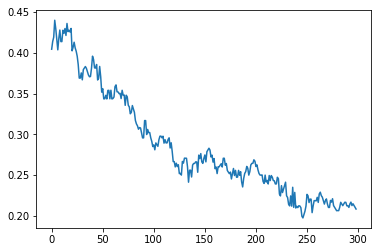

In [118]:
pd.DataFrame(metrics).mean(axis=1).plot()